# NMD on raw counts

- NMD-3b & NMD-T
- on raw counts
- compare with embeddings from PCA

## Load libraries

Kernel dies if I execute the following:

import os
import sys
hashseed = os.getenv('PYTHONHASHSEED')
if not hashseed:
    os.environ['PYTHONHASHSEED'] = '0'
    os.execv(sys.executable, [sys.executable] + sys.argv)

In [1]:
%%capture 
!pip install scanpy

In [2]:
%%capture 
!pip install KDEpy

In [3]:
import os
import sys

import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import spearmanr

# to be able to import from tools dir
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
# import pertpy as pt
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co
import tools.util_plot as nmd_plot

import warnings
warnings.filterwarnings("ignore")

In [139]:
from scipy.stats import kendalltau
import importlib

In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_reconstruction(
    X_reconstruction, X, title,hue=None, type="scatter", sample_fraction=None
):
    """Plot original sparse non-negative matrix against the reconstructed one

    Also computes the Pearson correlation between both

    Args:
        X_reconstruction (_type_): Reconstructed matrix, e.g. np.maximum(0, Theta)
        X (_type_): The original sparse non-negative matrix
        title (_type_): _description_
        type (str, optional): _description_. Defaults to "scatter".
        sample_fraction (_type_, optional): _description_. Defaults to None.
    """
    X_recon_max = np.max(X_reconstruction)
    X_max = np.max(X)
    max_axis = max(X_recon_max, X_max)
    correlation = np.corrcoef(X_reconstruction.flatten(), X.flatten())[0][1]

    df = pd.DataFrame(
        {"original": X.flatten(), "reconstruction": X_reconstruction.flatten()}
    )

    if sample_fraction:
        df = df.sample(frac=sample_fraction, axis=0)

    fig, ax = plt.subplots()
    match type:
        case "scatter":
            if hue is not None:
                p = sns.scatterplot(data=df, x="reconstruction", y="original", hue=hue, alpha=0.1)
            else:
                p = sns.scatterplot(data=df, x="reconstruction", y="original", alpha=0.1)
        # case "kde":
        # p = sns.kdeplot(X_reconstruction.flatten(), X.flatten())
        # p = sns.kdeplot(data=df, x="reconstruction", y="original")
    p.set_ylim(0, max_axis)
    p.set_xlim(0, max_axis)
    plt.suptitle(title)
    plt.title(f"Pearson correlation: {round(correlation, 3)}")
    plt.xlabel("Reconstruction")
    plt.ylabel("Original data")
    ax.axline(xy1=(0, 0), slope=1, linewidth=1, color="r")
    plt.show()


## Preprocessing
### Read data

In [5]:
data_path = "../../data/MOBA_scRNAseq/outs_S2"
data_all = sc.read_10x_h5(data_path + "/filtered_feature_bc_matrix.h5")
data_all

AnnData object with n_obs × n_vars = 1326 × 21982
    var: 'gene_ids', 'feature_types', 'genome'

In [6]:
data_all_pca = sc.read_h5ad("../../data/MOBA_scRNAseq/MOBA_intermediate_results/export_s2.h5ad")
data_all_pca

AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'total_counts', 'n_genes_by_counts', 'leiden_opt'
    var: 'total_counts', 'n_cells_by_counts', 'TU_ID', 'nb_overdisp_cutoff', 'pval_cluster_0', 'pval_cluster_1', 'pval_cluster_2', 'pval_cluster_3'
    uns: 'leiden', 'leiden_opt_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Aggregate probes through max-pooling

In [7]:
data_maxpool = up.prep_probe_BacSC_data(data_all, agg_fn=np.max)

Aggregating feature 100/5572
Aggregating feature 200/5572
Aggregating feature 300/5572
Aggregating feature 400/5572
Aggregating feature 500/5572
Aggregating feature 600/5572
Aggregating feature 700/5572
Aggregating feature 800/5572
Aggregating feature 900/5572
Aggregating feature 1000/5572
Aggregating feature 1100/5572
Aggregating feature 1200/5572
Aggregating feature 1300/5572
Aggregating feature 1400/5572
Aggregating feature 1500/5572
Aggregating feature 1600/5572
Aggregating feature 1700/5572
Aggregating feature 1800/5572
Aggregating feature 1900/5572
Aggregating feature 2000/5572
Aggregating feature 2100/5572
Aggregating feature 2200/5572
Aggregating feature 2300/5572
Aggregating feature 2400/5572
Aggregating feature 2500/5572
Aggregating feature 2600/5572
Aggregating feature 2700/5572
Aggregating feature 2800/5572
Aggregating feature 2900/5572
Aggregating feature 3000/5572
Aggregating feature 3100/5572
Aggregating feature 3200/5572
Aggregating feature 3300/5572
Aggregating feature

In [8]:
sc.pp.calculate_qc_metrics(data_maxpool, var_type="genes", percent_top=None, log1p=True, inplace=True)

print(f"Zero inflation of probe-wise data: {((np.prod(data_all.X.shape) - data_all.X.getnnz()) / np.prod(data_all.X.shape)).round(3)}")
print(f"Zero inflation of aggregated data: {((np.prod(data_maxpool.X.shape) - data_maxpool.X.getnnz()) / np.prod(data_maxpool.X.shape)).round(3)}")


Zero inflation of probe-wise data: 0.947
Zero inflation of aggregated data: 0.856


## Filter cells

Filter based on median absolute standard deviation:

- log1p_total_counts: count depth (number of counts per barcode)
- log1p_n_genes_by_counts: number of detected genes by barcode

Filter genes based on:
- min_cells = 2: at least gene is expressed in 2 cells

Further, filter cells based on:
- min_genes: at least 2 genes have to be expressed

In [9]:
importlib.reload(ut)
data_gene = ut.filter_outliers(data_maxpool, nmads=5, min_cells=2)
print(data_maxpool.obs.outlier.value_counts())
print(f"Total number of cells: {data_maxpool.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

False    1255
True       71
Name: outlier, dtype: int64
Total number of cells: 1326
Number of cells after filtering: 1255


AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

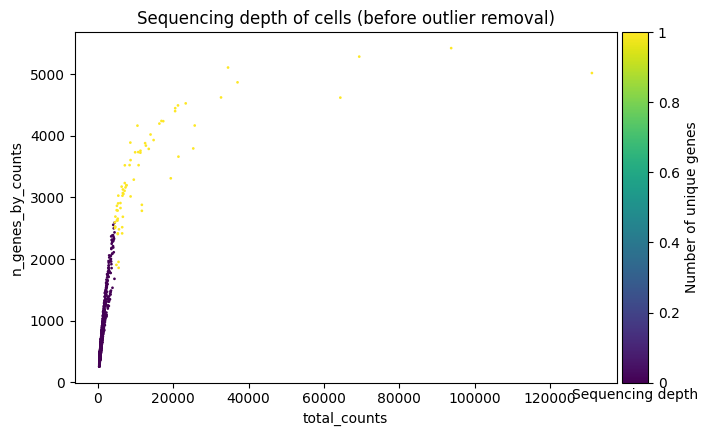

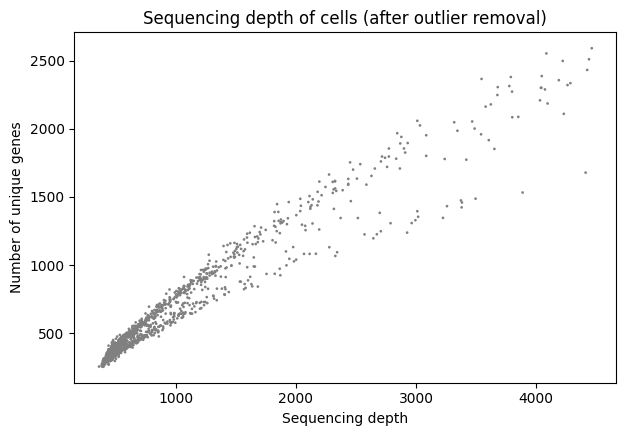

In [10]:
sc.pl.scatter(data_maxpool, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="viridis", title="Sequencing depth of cells (before outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly overdispersed. Therefore, we will use negative binomial count splitting

In [11]:
data_gene.layers["counts"] = data_gene.X.copy()

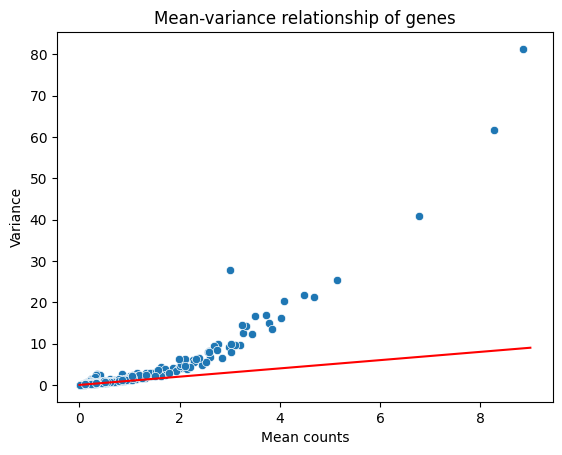

In [12]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

## Estimate negative binomial parameters for each gene

In [13]:
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="BFGS")
data_gene.var["nb_overdisp_cutoff_bfgs"] = data_gene.var["nb_overdisp_cutoff"]
data_gene.var["nb_overdisp_bfgs"] = data_gene.var["nb_overdisp"]


Fitting feature 100/5540
Fitting feature 200/5540
Fitting feature 300/5540
Fitting feature 400/5540
Fitting feature 500/5540
Fitting feature 600/5540
Fitting feature 700/5540
Fitting feature 800/5540
Fitting feature 900/5540
Fitting feature 1000/5540
Fitting feature 1100/5540
Fitting feature 1200/5540
Fitting feature 1300/5540
Fitting feature 1400/5540
Fitting feature 1500/5540
Fitting feature 1600/5540
Fitting feature 1700/5540
Fitting feature 1800/5540
Fitting feature 1900/5540
Fitting feature 2000/5540
Fitting feature 2100/5540
Fitting feature 2200/5540
Fitting feature 2300/5540
Fitting feature 2400/5540
Fitting feature 2500/5540
Fitting feature 2600/5540
Fitting feature 2700/5540
Fitting feature 2800/5540
Fitting feature 2900/5540
Fitting feature 3000/5540
Fitting feature 3100/5540
Fitting feature 3200/5540
Fitting feature 3300/5540
Fitting feature 3400/5540
Fitting feature 3500/5540
Fitting feature 3600/5540
Fitting feature 3700/5540
Fitting feature 3800/5540
Fitting feature 3900/

<Axes: xlabel='nb_mean', ylabel='Count'>

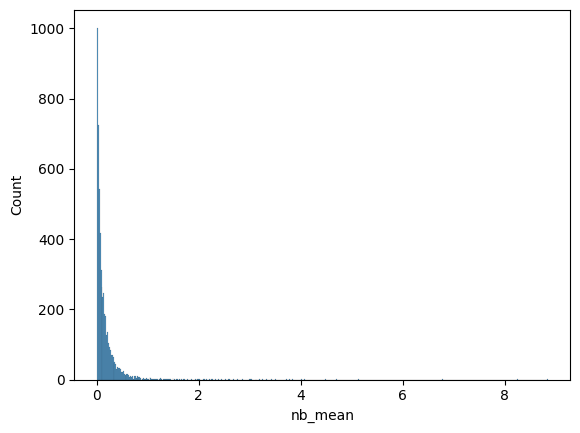

In [14]:
sns.histplot(data_gene.var["nb_mean"])

In [15]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="sctransform")

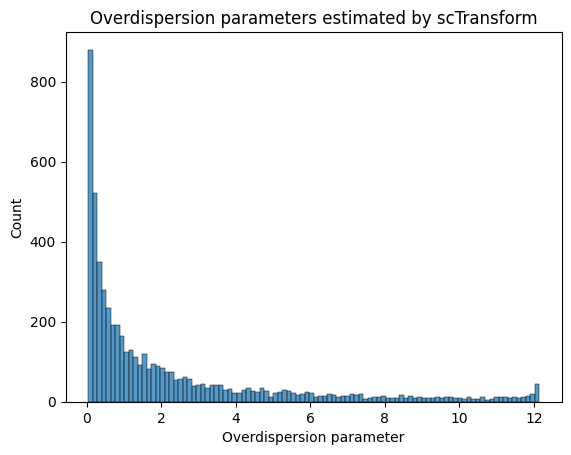

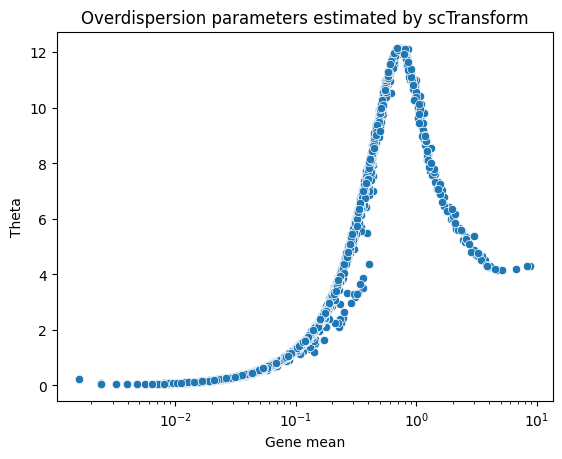

In [16]:
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Overdispersion parameter")
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

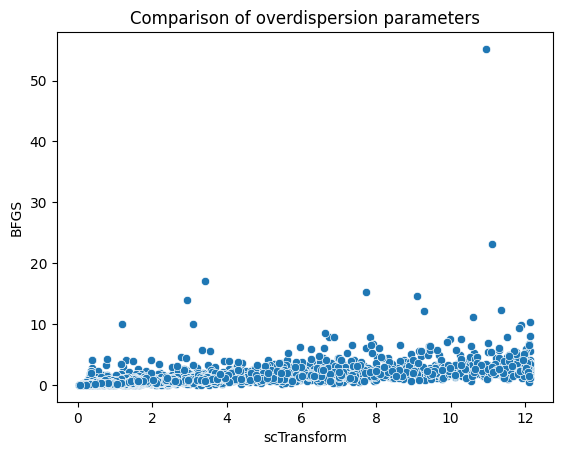

Correlation: [[1.        0.6281649]
 [0.6281649 1.       ]]


In [17]:
g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff_bfgs", x="nb_overdisp_cutoff")
plt.title("Comparison of overdispersion parameters")
plt.xlabel("scTransform")
plt.ylabel("BFGS")
plt.show()

print(f"Correlation: {np.corrcoef(data_gene.var['nb_overdisp_cutoff_bfgs'], data_gene.var['nb_overdisp_cutoff'])}")

In [18]:
data_gene.X = data_gene.layers["counts"].copy()

## Normalization, VST, scaling and PCA

In [19]:
# Normalizes X, such that: each barcode has total count equal to median of total counts before normalization
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)

# Only normalization
data_gene.layers["normalized_counts"] = data_gene.X.copy()

# Variance Stabilization Transformation
data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
data_gene.layers["vst_counts"] = data_gene.X.copy()

#min_vst_counts = data_gene.layers["vst_counts"].min()

# Scale data to unit variance and zero mean. Truncate values to 10
#sc.pp.scale(data_gene, max_value=10, zero_center=True)
# data_gene.X[np.isnan(data_gene.X)] = 0

# Apply full PCA
sc.tl.pca(data_gene, svd_solver='arpack')

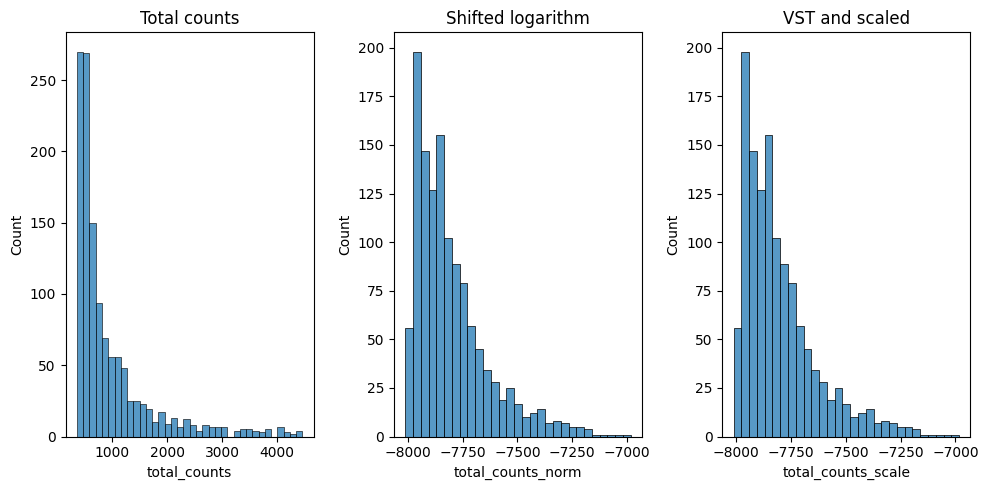

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

## Count-splitting into train and test data

In [21]:
data_train, data_test = cs.countsplit_adata(data_gene, data_dist="NB", beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)
print(data_train)

AnnData object with n_obs × n_vars = 1255 × 5426
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs'
    layers: 'counts'


Transformation of train and test data

In [22]:
# Normalizes X, such that: each barcode has total count equal to median of total counts before normalization
sc.pp.normalize_total(data_train, target_sum=None, layer=None)

# Only normalization
data_train.layers["normalized_counts"] = data_train.X.copy()

# Variance Stabilization Transformation
data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
data_train.layers["vst_counts_shifted"] = data_train.layers["vst_counts"].copy().todense() + data_train.layers["vst_counts"].min() * -1.

# test data
sc.pp.normalize_total(data_test, target_sum=None, layer=None)
data_test.layers["normalized_counts"] = data_test.X.copy()
data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_test.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
data_test.layers["vst_counts_shifted"] = data_test.layers["vst_counts"].copy().todense() + data_test.layers["vst_counts"].min() * -1.

## NMD 3-B

In [23]:
from tools import NMD as nmd

In [24]:
k_opt_3b = 2
beta_opt_3b = 0.6
data_layer = "counts"

In [25]:
m, n = data_gene.X.shape
X_nmd = ut.convert_to_dense_counts(data_gene, layer=data_layer)
m, n = X_nmd.shape
W0, H0 = cs.nuclear_norm_init(X_nmd, m, n, k_opt_3b)
Theta0 = W0 @ H0

In [26]:
Theta_3b, W_3b, H_3b, loss_3b, iters_3b, times_3b = nmd.nmd_3b(X_nmd, r=k_opt_3b, W0=W0, H0=H0, beta1=beta_opt_3b, tol_over_10iters=1e-5)

Running 3B-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 64.877848] - 0.301091 secs
[1 : 64.374550] - 0.300762 secs
[2 : 63.937710] - 0.296050 secs
[3 : 63.620204] - 0.298137 secs
[4 : 63.307485] - 0.301147 secs
[5 : 63.039253] - 0.296621 secs
[6 : 62.797403] - 0.297632 secs
[7 : 62.625370] - 0.301115 secs
[8 : 62.539569] - 0.298143 secs
[9 : 62.487814] - 0.298447 secs
[10 : 62.445400] - 0.300674 secs
[11 : 62.416984] - 0.296222 secs
[12 : 62.396471] - 0.296496 secs
[13 : 62.380746] - 0.300312 secs
[14 : 62.368321] - 0.297408 secs
[15 : 62.358314] - 0.301213 secs
[16 : 62.350287] - 0.303221 secs
[17 : 62.343812] - 0.297632 secs
[18 : 62.338482] - 0.296855 secs
[19 : 62.334162] - 0.300696 secs
[20 : 62.330637] - 0.296808 secs
[21 : 62.327608] - 0.299467 secs
[22 : 62.325108] - 0.308895 secs
[23 : 62.322956] - 0.296089 secs
[24 : 62.321186] - 0.300284 secs
[25 : 62.319639] - 0.300804 secs
[26 : 62.318334] - 0.300273 secs
[27 : 62.317237] - 0.298171 

In [50]:
data_all_pca.obs["leiden_opt"]

AAACCCATCGGTGCAC-1    0
AAACGCTAGGCGCTTC-1    1
AAAGAACAGCCTATTG-1    0
AAAGAACGTAATTGGA-1    0
AAAGGGCAGCGAGAAA-1    0
                     ..
TTTGACTAGTGGTTAA-1    1
TTTGACTCAAGGTCTT-1    2
TTTGACTTCTTCGGTC-1    1
TTTGACTTCTTTACAC-1    0
TTTGTTGGTAGTGGCA-1    0
Name: leiden_opt, Length: 1255, dtype: category
Categories (4, object): ['0', '1', '2', '3']

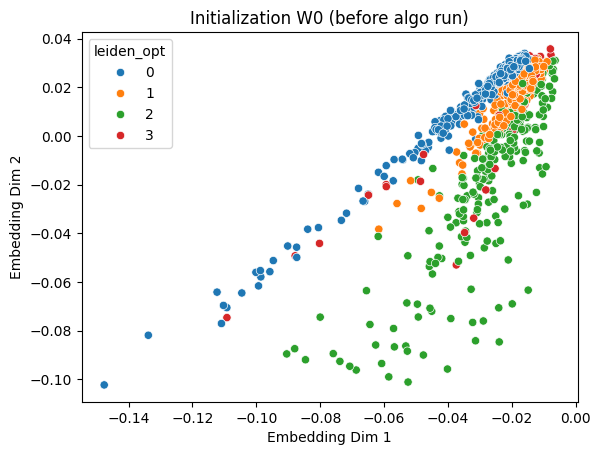

In [51]:
sns.scatterplot(x=W0[:,0], y=W0[:,1], hue=data_all_pca.obs["leiden_opt"]).set(title="Initialization W0 (before algo run)", xlabel = "Embedding Dim 1", ylabel = "Embedding Dim 2")
plt.show()

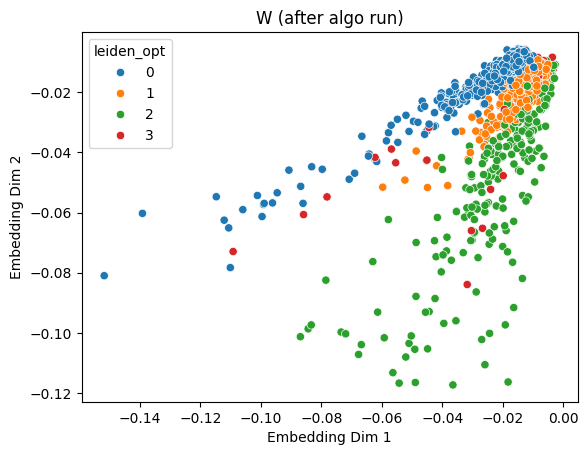

In [52]:
sns.scatterplot(x=W_3b[:,0], y=W_3b[:,1], hue=data_all_pca.obs["leiden_opt"]).set(title="W (after algo run)", xlabel = "Embedding Dim 1", ylabel = "Embedding Dim 2")
plt.show()

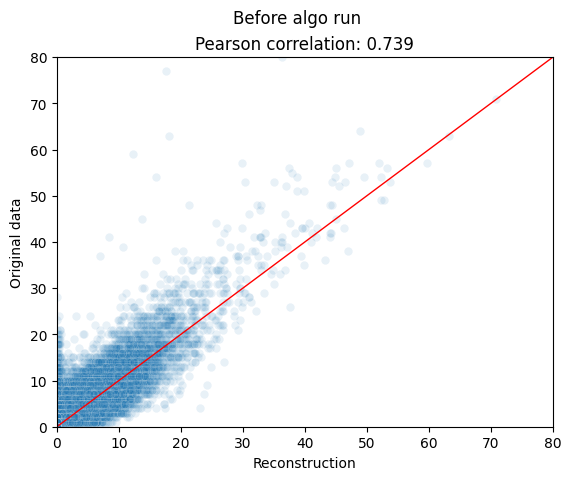

In [29]:
nmd_plot.plot_reconstruction(np.maximum(0, Theta0), X_nmd, "Before algo run", type="scatter", sample_fraction=None)

In [47]:
spearmanr(np.maximum(0, Theta0).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.4231025426184257, pvalue=0.0)

In [148]:
kendalltau(np.maximum(0, Theta0).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.4175662120421062, pvalue=0.0)

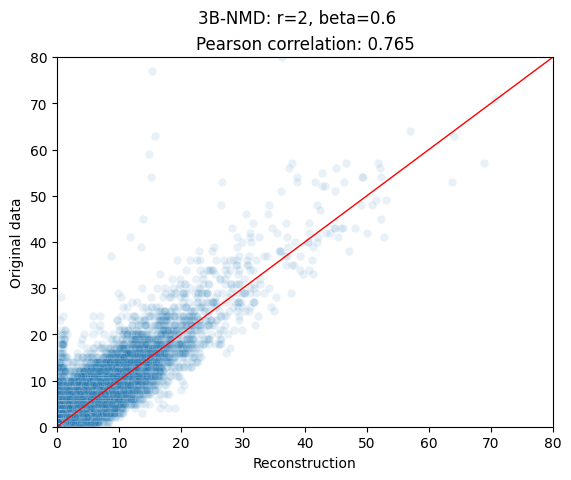

In [30]:
nmd_plot.plot_reconstruction(np.maximum(0, Theta_3b), X_nmd, "3B-NMD: r=2, beta=0.6", type="scatter", sample_fraction=None)

In [48]:
spearmanr(np.maximum(0, Theta_3b).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.46135199359289786, pvalue=0.0)

In [147]:
kendalltau(np.maximum(0, Theta_3b).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.4553742305957115, pvalue=0.0)

## NMD-T

In [31]:
k_opt_t = 2
beta_opt_t = 0.9

In [32]:
Theta_t, W_t, H_t, loss_t, iters_t, times_t = nmd.nmd_t(X_nmd, r=k_opt_t, W0=W0, H0=H0, beta1=beta_opt_t, tol_over_10iters=1e-4)

Running NMD-T, evolution of [iteration number : relative error in %] - time per iteration
[0 : 65.101650] - 0.313379 secs
[1 : 64.839597] - 0.319931 secs
[2 : 64.595004] - 0.313076 secs
[3 : 64.602984] - 0.319161 secs
[4 : 64.553010] - 0.316205 secs
[5 : 64.457125] - 0.312657 secs
[6 : 64.481003] - 0.315169 secs
[7 : 64.390804] - 0.316019 secs
[8 : 64.224239] - 0.310733 secs
[9 : 63.984181] - 0.319531 secs
[10 : 63.717479] - 0.315860 secs
[11 : 63.353601] - 0.313663 secs
[12 : 63.133852] - 0.318246 secs
[13 : 62.837349] - 0.317646 secs
[14 : 62.660917] - 0.312509 secs
[15 : 62.645941] - 0.319520 secs
[16 : 62.599408] - 0.315823 secs
[17 : 62.518577] - 0.314373 secs
[18 : 62.506874] - 0.315606 secs
[19 : 62.483699] - 0.317980 secs
[20 : 62.457265] - 0.313124 secs
[21 : 62.449777] - 0.318381 secs
[22 : 62.441988] - 0.315167 secs
[23 : 62.418816] - 0.313864 secs
[24 : 62.435343] - 0.313865 secs
[25 : 62.430773] - 0.316330 secs
[26 : 62.396556] - 0.311345 secs
[27 : 62.416431] - 0.315516 s

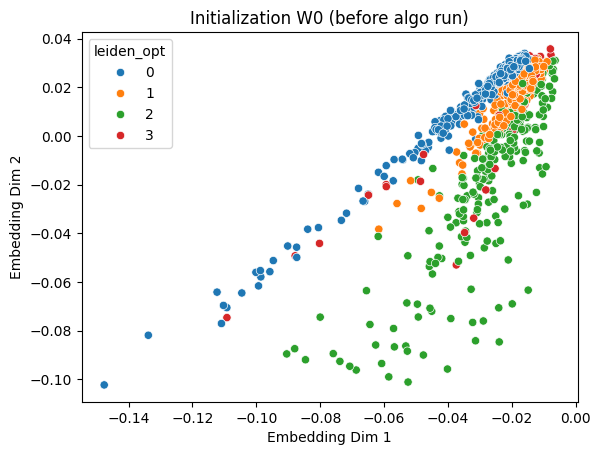

In [53]:
sns.scatterplot(x=W0[:,0], y=W0[:,1], hue=data_all_pca.obs["leiden_opt"]).set(title="Initialization W0 (before algo run)", xlabel = "Embedding Dim 1", ylabel = "Embedding Dim 2")
plt.show()

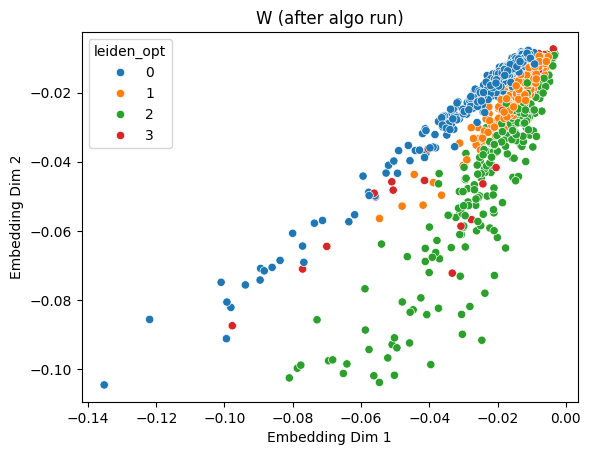

In [54]:
sns.scatterplot(x=W_t[:,0], y=W_t[:,1], hue=data_all_pca.obs["leiden_opt"]).set(title="W (after algo run)", xlabel = "Embedding Dim 1", ylabel = "Embedding Dim 2")
plt.show()

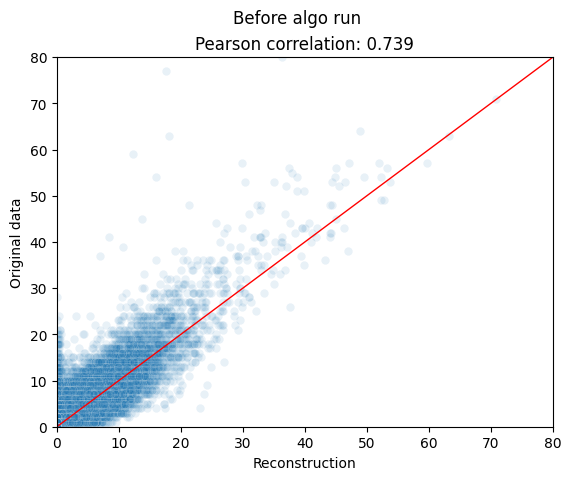

In [76]:
nmd_plot.plot_reconstruction(np.maximum(0, W0@H0), X_nmd, "Before algo run", type="scatter",  sample_fraction=None)

In [36]:
spearmanr(np.maximum(0, W0@H0).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.4231025426184257, pvalue=0.0)

In [146]:
kendalltau(np.maximum(0, W0@H0).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.4175662120421062, pvalue=0.0)

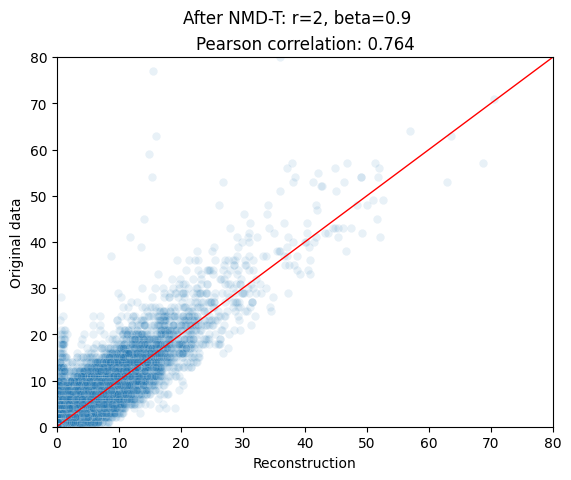

In [37]:
nmd_plot.plot_reconstruction(np.maximum(0, Theta_t), X_nmd, "After NMD-T: r=2, beta=0.9", type="scatter", sample_fraction=None)

In [38]:
spearmanr(np.maximum(0, Theta_t).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.46063273984258496, pvalue=0.0)

In [145]:
kendalltau(np.maximum(0, Theta_t).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.4546500603763598, pvalue=0.0)

In [135]:
spearmanr(np.maximum(0, Theta_t).flatten().round(0), np.maximum(0, Theta_3b).flatten().round(0))

SignificanceResult(statistic=0.988258899141801, pvalue=0.0)

## NMD-3B - latent dim 3

In [130]:
def plot_embedding_grid(embeddings, hue, title_prefix=""):
    """
    Plots a grid of scatterplots for all pairwise combinations of embeddings.

    :param embeddings: NumPy array of shape (n_samples, n_features)
    :param hue: Series or list of hue values for coloring points based on clustering
    :param title_prefix: Optional prefix for the plot titles
    """
    # Convert embeddings to a DataFrame
    df_embeddings = pd.DataFrame(embeddings)
    
    # Add the hue (clustering results) to the DataFrame
    df_embeddings['Cluster'] = list(hue)
    
    # Create pairplot
    g = sns.pairplot(df_embeddings, hue='Cluster', plot_kws={"s": 20, "alpha": 0.3})
    
    # Set titles for each subplot
    for i in range(df_embeddings.shape[1] - 1):
        for j in range(i + 1, df_embeddings.shape[1] - 1):
            # g.axes[j, i].set_title(f"{title_prefix}: Dim {i+1} vs Dim {j+1}")
            g.axes[j, i].set_xlabel(f"Embedding Dim {i+1}")
            g.axes[j, i].set_ylabel(f"Embedding Dim {j+1}")

    plt.show()

In [122]:
k_opt_3b5 = 3
beta_opt_3b5 = 0.9
data_layer = "counts"

In [123]:
m, n = data_gene.X.shape
X_nmd = ut.convert_to_dense_counts(data_gene, layer=data_layer)
m, n = X_nmd.shape
W0_3b5, H0_3b5 = cs.nuclear_norm_init(X_nmd, m, n, k_opt_3b5)
Theta0_3b5 = W0_3b5 @ H0_3b5

In [124]:
Theta_3b5, W_3b5, H_3b5, loss_3b5, iters_3b5, times_3b5 = nmd.nmd_3b(X_nmd, r=k_opt_3b5, W0=W0_3b5, H0=H0_3b5, beta1=beta_opt_3b5, tol_over_10iters=1e-4)

Running 3B-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 63.272806] - 0.309565 secs
[1 : 63.281931] - 0.310459 secs
[2 : 63.263541] - 0.304838 secs
[3 : 63.183776] - 0.306284 secs
[4 : 63.026812] - 0.312148 secs
[5 : 63.122643] - 0.300950 secs
[6 : 62.934556] - 0.304110 secs
[7 : 63.071741] - 0.310186 secs
[8 : 62.895553] - 0.303720 secs
[9 : 62.943358] - 0.308654 secs
[10 : 62.927401] - 0.303175 secs
[11 : 62.854341] - 0.302318 secs
[12 : 62.830826] - 0.299353 secs
[13 : 62.908434] - 0.311259 secs
[14 : 62.884760] - 0.304730 secs
[15 : 62.746082] - 0.304538 secs
[16 : 62.796135] - 0.304430 secs
[17 : 62.711344] - 0.295990 secs
[18 : 62.679651] - 0.296737 secs
[19 : 62.711721] - 0.303866 secs
[20 : 62.820184] - 0.303112 secs
[21 : 62.637386] - 0.306893 secs
[22 : 62.602811] - 0.309524 secs
[23 : 62.651799] - 0.301166 secs
[24 : 62.614345] - 0.297404 secs
[25 : 62.608858] - 0.300364 secs
[26 : 62.573421] - 0.302423 secs
[27 : 62.646884] - 0.302340 

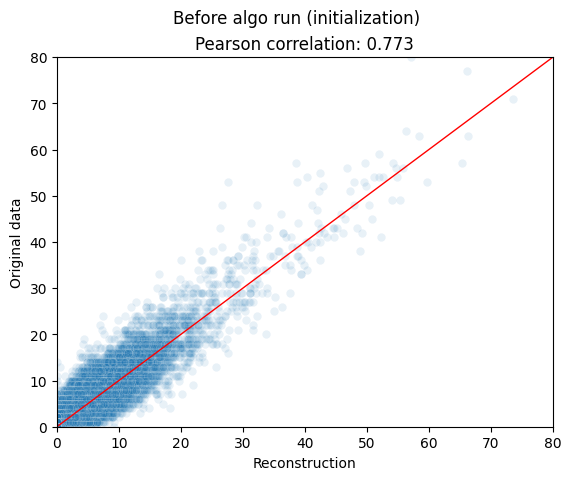

In [42]:
nmd_plot.plot_reconstruction(np.maximum(0, W0_3b5@H0_3b5), X_nmd, "Before algo run (initialization)", type="scatter", sample_fraction=None)

In [43]:
spearmanr(np.maximum(0, W0_3b5@H0_3b5).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.44907951750884095, pvalue=0.0)

In [144]:
kendalltau(np.maximum(0, W0_3b5@H0_3b5).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.4339335320646287, pvalue=0.0)

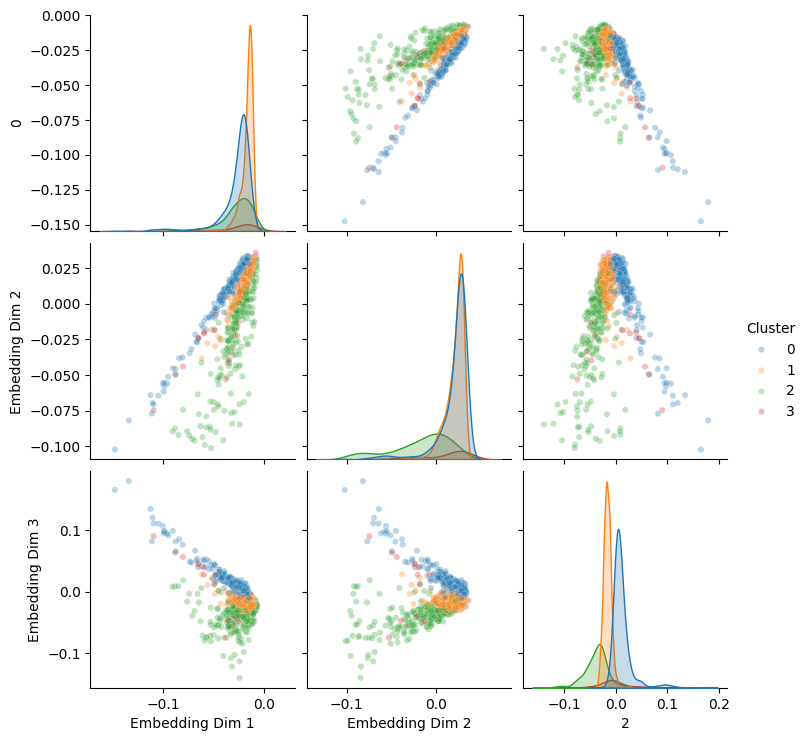

In [131]:
plot_embedding_grid(W0_3b5, hue = data_all_pca.obs["leiden_opt"], title_prefix="After nuclear init")

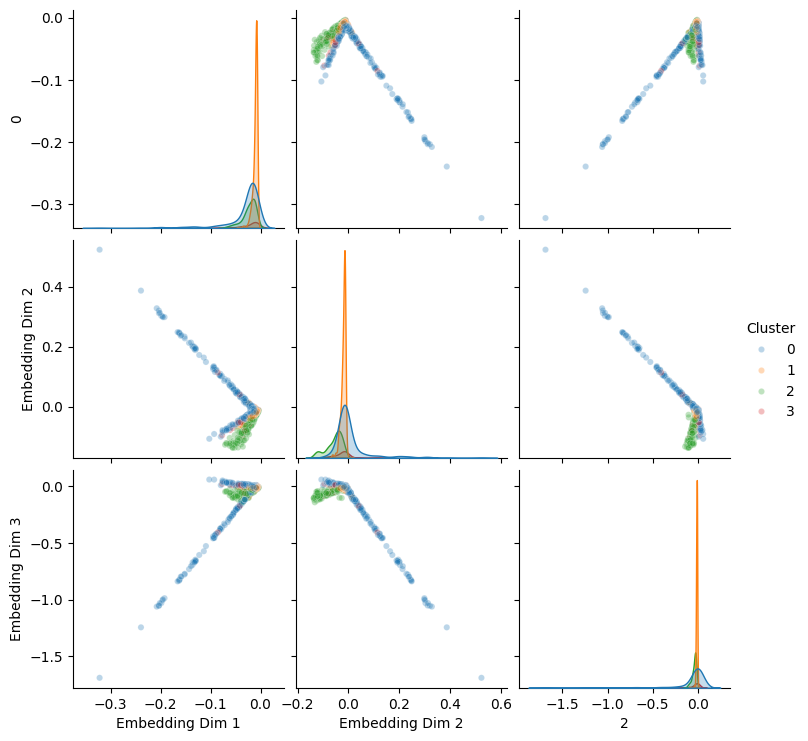

In [132]:
plot_embedding_grid(W_3b5, hue = data_all_pca.obs["leiden_opt"], title_prefix="NMD-B (r=3, beta=0.9)")

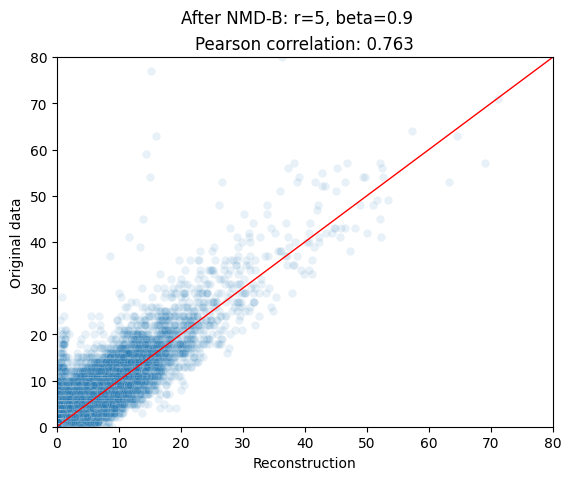

In [133]:
nmd_plot.plot_reconstruction(np.maximum(0, Theta_3b5), X_nmd, "After NMD-B: r=5, beta=0.9", type="scatter", sample_fraction=None)

In [134]:
spearmanr(np.maximum(0, Theta_3b5).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.4592992114735662, pvalue=0.0)

In [143]:
kendalltau(np.maximum(0, Theta_3b5).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.4533353435387929, pvalue=0.0)